# Backtest com Bollinger Bands para Ações da B3

Este notebook realiza um backtest simples utilizando Bollinger Bands para operações de **compra**.

Cada ativo inicia com um capital de **R$ 1000**, e a estratégia é:
- **Entrada:** Compra no fechamento, caso feche abaixo da banda inferior.
- **Saída:**  
  - **Stop loss:** -5% abaixo do preço de entrada.
  - **Take profit:** Quando o preço atinge a banda superior.

No final, exibimos:
* O **resumo dos trades**  
* A **evolução do capital** *(Equity Curve)*  
* Gráficos **limpos e fáceis de interpretar**  

#### Documentação Metatrader5 com Python
* https://www.mql5.com/pt/docs/python_metatrader5
* https://www.metatrader5.com/pt/metaeditor/help/development/python

## 1. Importação de Bibliotecas

In [ ]:
# Instale os pacotes necessários antes de rodar o código
# !pip install MetaTrader5
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Configuração global dos gráficos
plt.style.use("seaborn-darkgrid")
plt.rcParams.update({'figure.figsize': (12, 6), 'axes.grid': True})

C:\Users\Sonata\AppData\Local\Temp\ipykernel_1528\1667908083.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


## 2. Conexão com o MetaTrader 5 e Coleta de Dados

In [2]:
# Inicializa a conexão com o MT5
if not mt5.initialize():
    print("Falha ao conectar no MT5:", mt5.last_error())
    quit()
else:
    print("Conectado ao MetaTrader 5!")

# Lista de ativos analisados
symbols = ["PETR4", "VALE3", "ITUB4", "BBDC4"]

# Período de análise: últimos 365 dias
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

Conectado ao MetaTrader 5!


In [3]:
# Dicionário para armazenar os dados de cada ativo
data = {}

for symbol in symbols:
    if not mt5.symbol_select(symbol, True):
        print(f"Não foi possível selecionar {symbol}.")
        continue
    rates = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_D1, start_date, end_date)
    if rates is None or len(rates) == 0:
        print(f"Dados não encontrados para {symbol}.")
        continue
        
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    data[symbol] = df
    print(f"Dados de {symbol} coletados com sucesso!")

if not data:
    print("Nenhum dado foi coletado. Verifique a conexão.")
    mt5.shutdown()
    quit()

Dados de PETR4 coletados com sucesso!
Dados de VALE3 coletados com sucesso!
Dados de ITUB4 coletados com sucesso!
Dados de BBDC4 coletados com sucesso!


In [4]:
data['PETR4'].head()

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2024-03-19,29.80,30.17,29.12,29.53,64933,1,48345400
2024-03-20,29.66,30.08,29.32,30.05,49855,1,38796600
2024-03-21,30.17,30.34,29.21,29.23,58373,1,46900700
2024-03-22,29.39,29.66,29.01,29.52,47410,1,34332500
2024-03-25,29.62,30.16,29.61,29.97,37977,1,26800000


## 3. Cálculo das Bollinger Bands

In [5]:
def calculate_bollinger_bands(df, window=20, num_std=2):
    df["SMA"] = df["close"].rolling(window).mean()
    df["STD"] = df["close"].rolling(window).std()
    df["LowerBand"] = df["SMA"] - num_std * df["STD"]
    df["UpperBand"] = df["SMA"] + num_std * df["STD"]
    df.dropna(inplace=True)
    return df

for symbol in data:
    data[symbol] = calculate_bollinger_bands(data[symbol])

In [6]:
data['PETR4'].head()

,open,high,low,close,tick_volume,spread,real_volume,SMA,STD,LowerBand,UpperBand
time,,,,,,,,,,,
2024-04-16,31.94,32.51,31.89,32.33,69154,1,37099300,30.9490,1.060268,28.828465,33.069535
2024-04-17,32.33,32.71,32.21,32.57,63083,1,39033200,31.1010,1.064034,28.972933,33.229067
2024-04-18,32.75,33.23,32.46,32.63,93512,1,45005400,31.2300,1.086075,29.057851,33.402149
2024-04-19,32.79,33.63,32.62,33.18,106796,1,80354200,31.4275,1.062122,29.303255,33.551745
2024-04-22,33.37,34.05,33.18,33.98,76597,1,51623700,31.6505,1.107774,29.434952,33.866048


## 4.Implementação do Backtest

In [7]:
def backtest_bollinger(df, initial_capital=1000.0, stop_loss_perc=0.05):
    trades = []
    equity_curve = []
    capital = initial_capital
    position_active = False

    i = 0
    while i < len(df):
        current_day = df.iloc[i]
        current_date = df.index[i]
        
        equity_curve.append((current_date, capital))

        if not position_active and current_day["close"] < current_day["LowerBand"]:
            entry_date = current_date
            entry_price = current_day["close"]
            stop_loss = entry_price * (1 - stop_loss_perc)
            position_size = capital / entry_price
            position_active = True
            
        elif position_active:
            exit_price = None

            if current_day["low"] <= stop_loss:
                exit_price = stop_loss
            elif current_day["high"] >= current_day["UpperBand"]:
                exit_price = current_day["UpperBand"]

            if exit_price:
                exit_date = current_date
                new_capital = position_size * exit_price
                trade_return = (exit_price - entry_price) / entry_price * 100
                
                trades.append({
                    "Entry Date": entry_date,
                    "Exit Date": exit_date,
                    "Entry Price": entry_price,
                    "Exit Price": exit_price,
                    "Return (%)": trade_return,
                    "Capital": new_capital
                })
                
                capital = new_capital
                position_active = False
                
        i += 1

    if position_active:
        final_date = df.index[-1]
        final_price = df.iloc[-1]["close"]
        new_capital = position_size * final_price
        trades.append({
            "Entry Date": entry_date,
            "Exit Date": final_date,
            "Entry Price": entry_price,
            "Exit Price": final_price,
            "Return (%)": (final_price - entry_price) / entry_price * 100,
            "Capital": new_capital
        })
        capital = new_capital
        equity_curve.append((final_date, capital))

    equity_df = pd.DataFrame(equity_curve, columns=["Date", "Capital"]).set_index("Date")
    trades_df = pd.DataFrame(trades)
    
    return trades_df, equity_df, capital

## 5. Execução do Backtest e Exibição dos Resultados


Backtest para PETR4
  Entry Date  Exit Date  Entry Price  Exit Price  Return (%)      Capital
0 2024-06-14 2024-07-01        31.41   35.005238   11.446157  1114.461567
1 2024-07-29 2024-08-05        33.40   31.730000   -5.000000  1058.738489
2 2025-02-12 2025-02-17        36.28   37.830105    4.272614  1103.974302
3 2025-03-05 2025-03-18        34.62   36.150000    4.419411  1152.763461
Capital final para PETR4: R$ 1152.76


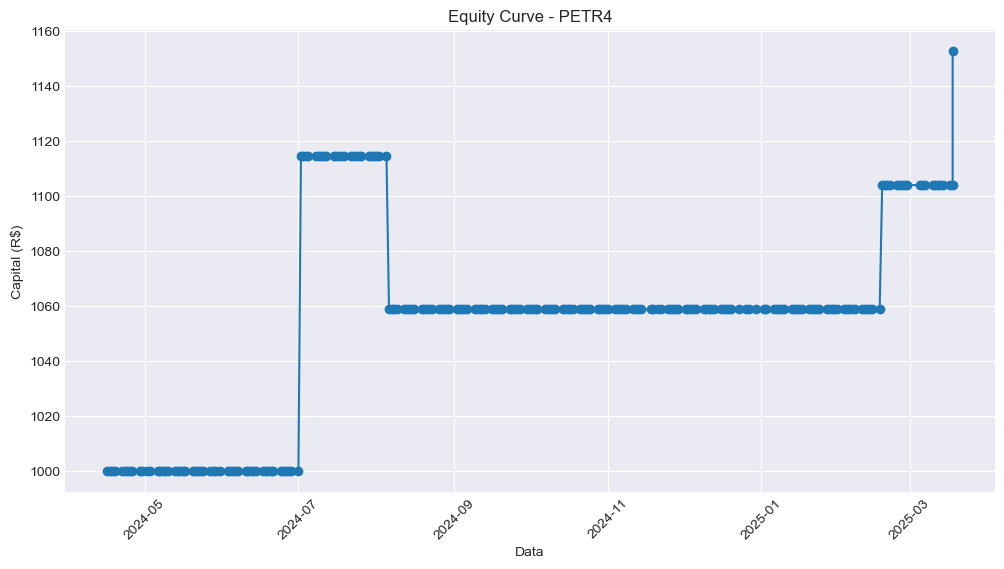


Backtest para VALE3
  Entry Date  Exit Date  Entry Price  Exit Price  Return (%)      Capital
0 2024-06-03 2024-06-28        57.32   57.480448    0.279916  1002.799165
1 2024-07-23 2024-08-14        55.80   53.010000   -5.000000   952.659206
2 2024-11-11 2024-12-09        56.02   57.290172    2.267355   974.259375
3 2024-12-18 2025-01-07        52.75   50.112500   -5.000000   925.546406
Capital final para VALE3: R$ 925.55


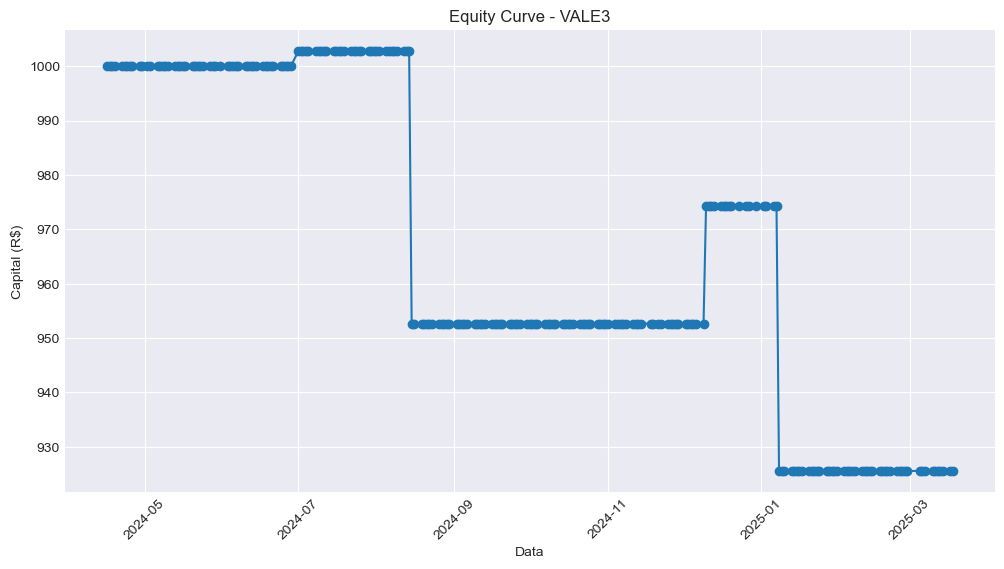


Backtest para ITUB4
  Entry Date  Exit Date  Entry Price  Exit Price  Return (%)      Capital
0 2024-05-31 2024-06-20        26.29   27.332019    3.963557  1039.635573
1 2024-09-20 2024-10-28        30.89   30.819991   -0.226639  1037.279356
2 2024-11-28 2024-12-23        28.12   26.714000   -5.000000   985.415388
Capital final para ITUB4: R$ 985.42


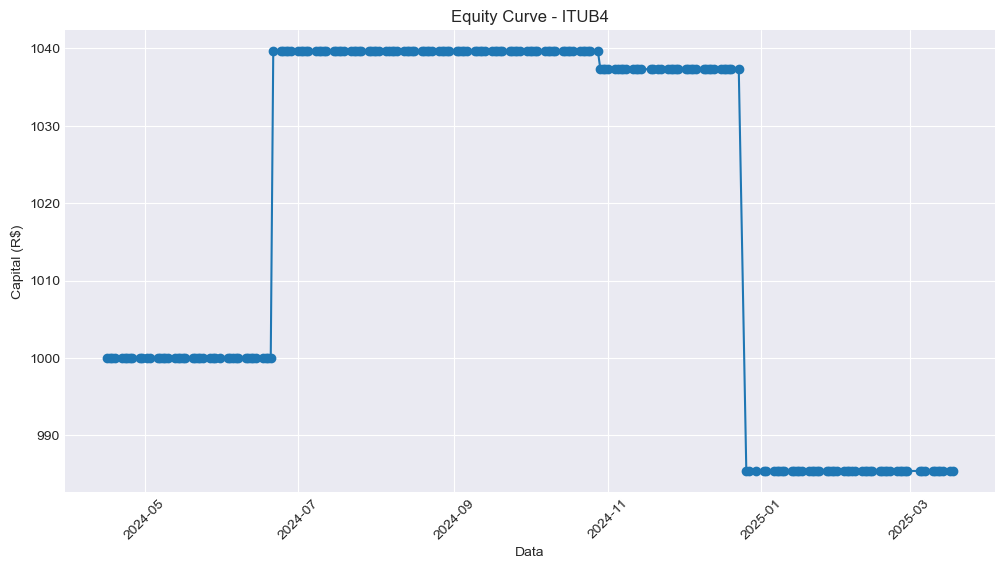


Backtest para BBDC4
  Entry Date  Exit Date  Entry Price  Exit Price  Return (%)     Capital
0 2024-05-10 2024-05-29        12.44   11.818000   -5.000000  950.000000
1 2024-09-18 2024-09-23        14.63   13.898500   -5.000000  902.500000
2 2024-09-24 2024-10-29        13.77   14.941313    8.506268  979.269067
3 2024-10-31 2024-11-06        13.97   13.271500   -5.000000  930.305614
4 2024-11-07 2024-11-28        13.29   12.625500   -5.000000  883.790333
5 2024-11-29 2024-12-16        12.29   11.675500   -5.000000  839.600816
6 2025-02-28 2025-03-17        11.22   12.384815   10.381591  926.764740
Capital final para BBDC4: R$ 926.76


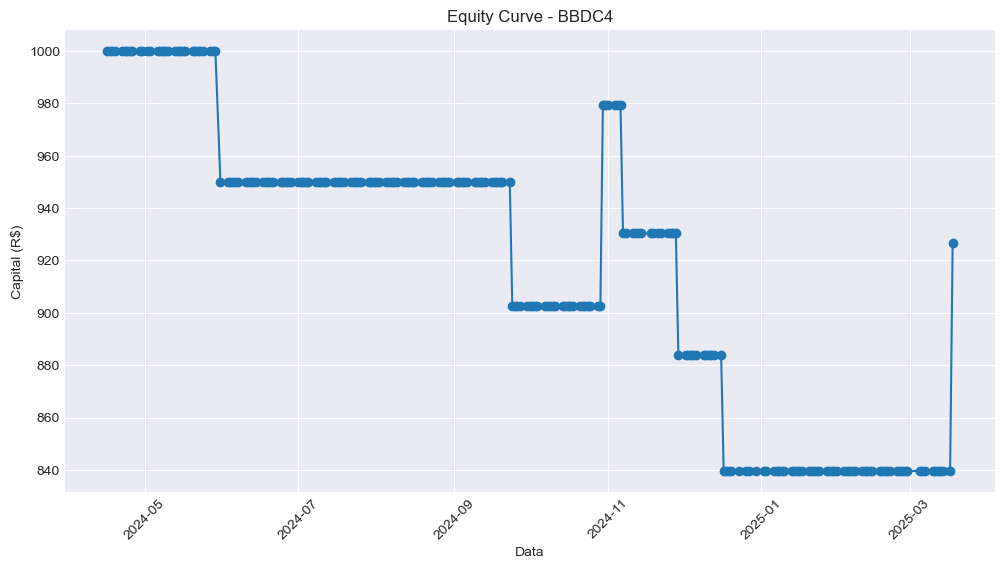

In [8]:
# Dicionário para armazenar os resultados
results = {}

for symbol in symbols:
    if symbol not in data:
        continue
    print(f"\nBacktest para {symbol}")
    df = data[symbol].copy()
    trades_df, equity_df, final_capital = backtest_bollinger(df, initial_capital=1000.0)
    results[symbol] = {"trades": trades_df, "equity": equity_df, "final_capital": final_capital}
    
    print(trades_df)
    print(f"Capital final para {symbol}: R$ {final_capital:.2f}")
    
    # Gráfico da evolução do capital
    plt.figure()
    plt.plot(equity_df.index, equity_df["Capital"], marker="o", linestyle="-")
    plt.title(f"Equity Curve - {symbol}")
    plt.xlabel("Data")
    plt.ylabel("Capital (R$)")
    plt.xticks(rotation=45)
    plt.show()

In [9]:
# Dicionário para armazenar os resultados
summary_results = {}

for symbol in symbols:
    if symbol not in results:
        continue
    
    trades_df = results[symbol]["trades"]
    final_capital = results[symbol]["final_capital"]
    
    total_trades = len(trades_df)
    total_return = (final_capital - 1000) / 1000 * 100
    avg_return = trades_df["Return (%)"].mean() if not trades_df.empty else 0
    win_rate = (trades_df["Return (%)"] > 0).mean() * 100 if not trades_df.empty else 0
    
    summary_results[symbol] = {
        "Final Capital (R$)": round(final_capital, 2),
        "Total Trades": total_trades,
        "Total Return (%)": round(total_return, 2),
        "Avg Return per Trade (%)": round(avg_return, 2),
        "Win Rate (%)": round(win_rate, 2)
    }

# Criando um DataFrame para visualização
summary_df = pd.DataFrame(summary_results).T

In [10]:
# Resumo dos resultados
summary_df

,Final Capital (R$),Total Trades,Total Return (%),Avg Return per Trade (%),Win Rate (%)
PETR4,1152.76,4.0,15.28,3.78,75.00
VALE3,925.55,4.0,-7.45,-1.86,50.00
ITUB4,985.42,3.0,-1.46,-0.42,33.33
BBDC4,926.76,7.0,-7.32,-0.87,28.57


## 6. Encerramento da Conexão com o MT5

In [11]:
mt5.shutdown()
print("Conexão com o MT5 encerrada com sucesso!")

Conexão com o MT5 encerrada com sucesso!
